In [4]:
# Add relevant Jupyter notebook extensions 

In [ ]:
# You can double-check your Python path like this...
import sys  
print(sys.path)

['/Users/supremedictator/Desktop/Github Repo/SupremeDictatorI/Engineering Science/B1 Engineering Computation/B1-Coding-Practical-UUV', '/opt/homebrew/Caskroom/miniforge/base/envs/B1/lib/python314.zip', '/opt/homebrew/Caskroom/miniforge/base/envs/B1/lib/python3.14', '/opt/homebrew/Caskroom/miniforge/base/envs/B1/lib/python3.14/lib-dynload', '', '/opt/homebrew/Caskroom/miniforge/base/envs/B1/lib/python3.14/site-packages']


# Simulate closed-loop
After implementing your control functionality, you can simulate the closed-loop with code that looks something like this...

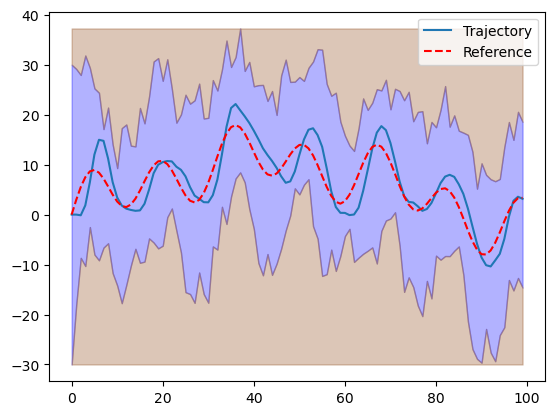

In [11]:
# Import relevant modules
from uuv_mission.control import Controller
from uuv_mission.dynamic import Submarine, Mission, ClosedLoop, Trajectory

sub = Submarine()
controller = Controller(KP=0.15, KD=0.6)

# Instantiate your controller (depending on your implementation)
closed_loop = ClosedLoop(sub, controller)
mission = Mission.from_csv("../data/mission.csv") # You must implement this method in the Mission class

trajectory = closed_loop.simulate_with_random_disturbances(mission)
trajectory.plot_completed_mission(mission)